## ARIMAで1時間後を予測し、予測値をを用いて再度予測モデルを構築し1時間後の予測をする  
## 上記を120回(5日分)繰り返した後、観測値・予測値をカテゴリーに分類した上で精度を計る 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
%matplotlib inline

In [2]:
#trainデータ
#df=pd.read_csv("/Users/masanoritakahashi/Documents/forecast_PM2.5/modefied_data/rohini_1016_6hours.csv").iloc[:,1:]
#検証用データ
#test=pd.read_csv("/Users/masanoritakahashi/Documents/forecast_PM2.5/modefied_data/rohini_1113_6hours.csv").iloc[:,1:]

In [131]:
df=pd.read_csv("/Users/masanoritakahashi/Documents/aqi/modefieddata/rohini_1015.csv").iloc[:,1:]

In [132]:
df

,rohini,utc_time
0,19.0,2019-07-17 00:00:00
1,27.0,2019-07-17 01:00:00
2,13.0,2019-07-17 02:00:00
3,9.0,2019-07-17 03:00:00
4,12.0,2019-07-17 04:00:00
...,...,...
1900,61.0,2019-10-04 04:00:00
1901,51.0,2019-10-04 05:00:00
1902,46.0,2019-10-04 06:00:00
1903,42.0,2019-10-04 07:00:00


In [133]:
df.isnull().sum()

rohini      105
utc_time      0
dtype: int64

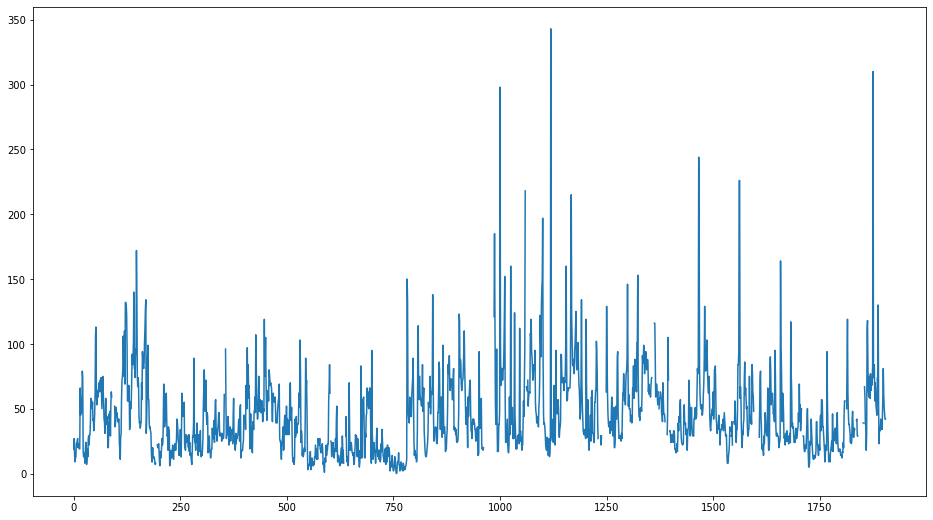

In [134]:
plt.figure(figsize=(16,9))
plt.plot(df["rohini"])

In [135]:
#7/17 00:00〜09/29 08:00までをtrain
train=df[:-120]
#09/29 09:00　〜 10/04 08:00までの5日間を予測
test=df[-120:]

In [136]:
train.head()

,rohini,utc_time
0,19.0,2019-07-17 00:00:00
1,27.0,2019-07-17 01:00:00
2,13.0,2019-07-17 02:00:00
3,9.0,2019-07-17 03:00:00
4,12.0,2019-07-17 04:00:00


In [137]:
train.tail()

,rohini,utc_time
1780,46.0,2019-09-29 04:00:00
1781,17.0,2019-09-29 05:00:00
1782,30.0,2019-09-29 06:00:00
1783,25.0,2019-09-29 07:00:00
1784,31.0,2019-09-29 08:00:00


In [138]:
test.head()

,rohini,utc_time
1785,34.0,2019-09-29 09:00:00
1786,35.0,2019-09-29 10:00:00
1787,35.0,2019-09-29 11:00:00
1788,27.0,2019-09-29 12:00:00
1789,23.0,2019-09-29 13:00:00


In [139]:
test.tail()

,rohini,utc_time
1900,61.0,2019-10-04 04:00:00
1901,51.0,2019-10-04 05:00:00
1902,46.0,2019-10-04 06:00:00
1903,42.0,2019-10-04 07:00:00
1904,42.0,2019-10-04 08:00:00


In [140]:
f=lambda x:datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

train["utc_time"]=train["utc_time"].apply(f)
test["utc_time"]=test["utc_time"].apply(f)

In [141]:
ts=train["rohini"].interpolate('linear')
ts.index=train["utc_time"]

ts_test=test["rohini"].interpolate('linear')
ts_test.index=test["utc_time"]

# ADF 検定  
単位根過程（非定常過程）かどうかの検定  
時系列解析は定常性が鍵  
→p値　が5%以下ならば定常と言える

In [122]:
res_ctt=sm.tsa.stattools.adfuller(ts, regression="ctt")
res_ct=sm.tsa.stattools.adfuller(ts, regression="ct")
res_c=sm.tsa.stattools.adfuller(ts, regression="c")
res_nc=sm.tsa.stattools.adfuller(ts, regression="nc")

print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-4.454830158005869, 0.007601468833599467, 25, 1759, {'1%': -4.377729585695182, '5%': -3.835751477461329, '10%': -3.5553422226482105}, 15828.903083452782)
(-4.426011037262289, 0.0019895610153666202, 25, 1759, {'1%': -3.96392594361226, '5%': -3.4129888923675034, '10%': -3.128521198757608}, 15827.215681797028)
(-4.4213253536960195, 0.0002720732456456764, 25, 1759, {'1%': -3.4340730634421153, '5%': -2.8631845252929495, '10%': -2.5676454956964605}, 15825.382901791729)
(-1.7177267052803602, 0.08136930799062725, 25, 1759, {'1%': -2.567012235342255, '5%': -1.9411537822214653, '10%': -1.6166698776148534}, 15840.133348095746)


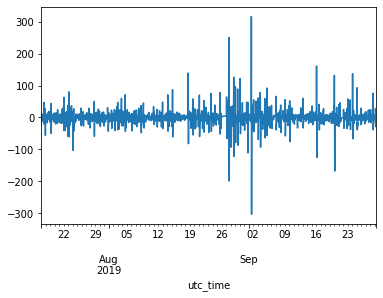

In [142]:
#差分
ts_diff=ts.diff().dropna()
ts_diff.plot()

### この後の流れ(以下を120回繰り返す)  
- ARIMAのモデル構築  
- 現時点の時間の取得  
- 1時間後を予測  
- pandasのSeriesとして追加  
- パラメータ推定  
- モデル作り  
- 現時点の時間の取得  
- 1時間後を予測  
...

In [124]:
#推定が遅いのでパラメータは固定のものを使用

#ARIMAのパレメータ取得
param=sm.tsa.arma_order_select_ic(ts_diff, ic="aic", trend="nc")

p=param["aic_min_order"][0]
q=param["aic_min_order"][1]

In [143]:
forecast_days=5
for i in range(forecast_days*24):
    print(i)

    #モデル構築
    sarimax=sm.tsa.SARIMAX(ts,
                          order=(p,1,q),
                          seasonal_order=(1,1,1,24),
                           enforce_stationaly=False,
                           enforce_invertibility = False
                          ).fit()
    print(sarimax.aic)

    #現時点の時間を取得
    now=ts[-1:].index[0]
    #1時間後の時間
    nexttime=now + datetime.timedelta(hours=1)

    #文字列への変換
    now_string=now.strftime('%Y-%m-%d %H:%M:%S')
    nexttime_string=nexttime.strftime('%Y-%m-%d %H:%M:%S')
    
    print(now)

    #予測
    sarimax_pred=sarimax.predict(nexttime_string, nexttime_string)

    #Seriesに追加
    ts=ts.append(sarimax_pred)

0
15958.038760451687
2019-09-29 08:00:00
1
15965.225969553032
2019-09-29 09:00:00
2
15972.47113003657
2019-09-29 10:00:00
3
15846.171135825585
2019-09-29 11:00:00
4
15991.214724640427
2019-09-29 12:00:00
5
16000.071192546564
2019-09-29 13:00:00
6
15868.590417982043
2019-09-29 14:00:00
7
16015.253228117446
2019-09-29 15:00:00
8
15896.08128094953
2019-09-29 16:00:00
9
16031.484851110054
2019-09-29 17:00:00
10
16038.488857539018
2019-09-29 18:00:00
11
16047.172473983
2019-09-29 19:00:00
12
16054.655525206723
2019-09-29 20:00:00
13
16064.593233251084
2019-09-29 21:00:00
14
15954.136335943336
2019-09-29 22:00:00
15
16080.243919127868
2019-09-29 23:00:00
16
16028.469780224324
2019-09-30 00:00:00
17
15956.290371623803
2019-09-30 01:00:00
18
16046.711804399965
2019-09-30 02:00:00
19
16027.102099968723
2019-09-30 03:00:00
20
16121.681115060688
2019-09-30 04:00:00
21
16126.911641869741
2019-09-30 05:00:00
22
16135.195533590111
2019-09-30 06:00:00
23
16116.460195551872
2019-09-30 07:00:00
24
1609

In [175]:
df=pd.DataFrame(ts_test[0:120])
df["forecast"]=ts[-120:]


In [214]:
df["diff"]=np.sqrt((df["rohini"]-df["forecast"])**2)

In [215]:
df.to_csv("ARIMA_forecast_repeat.csv")

In [208]:
ts[-120:]

2019-09-29 09:00:00    27.128122
2019-09-29 10:00:00    21.949111
2019-09-29 11:00:00    23.225191
2019-09-29 12:00:00    20.980040
2019-09-29 13:00:00    27.363374
                         ...    
2019-10-04 04:00:00    45.966137
2019-10-04 05:00:00    33.975615
2019-10-04 06:00:00    30.049233
2019-10-04 07:00:00    31.128932
2019-10-04 08:00:00    29.861029
Length: 120, dtype: float64

In [209]:
ts_test[0:120]

utc_time
2019-09-29 09:00:00    34.0
2019-09-29 10:00:00    35.0
2019-09-29 11:00:00    35.0
2019-09-29 12:00:00    27.0
2019-09-29 13:00:00    23.0
                       ... 
2019-10-04 04:00:00    61.0
2019-10-04 05:00:00    51.0
2019-10-04 06:00:00    46.0
2019-10-04 07:00:00    42.0
2019-10-04 08:00:00    42.0
Name: rohini, Length: 120, dtype: float64

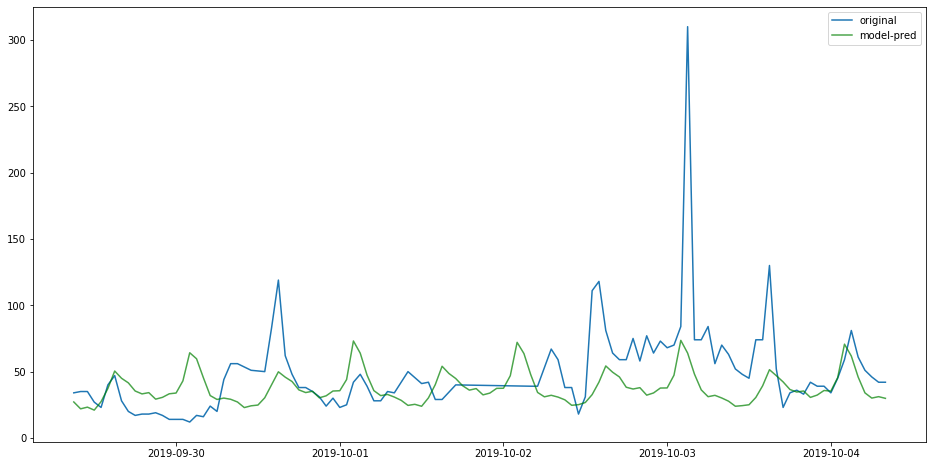

In [218]:
#09/29 09:00　〜 10/04 08:00までの5日間を予測
sarimax_pred_forecast=sarimax.predict("2019-09-29 09:00:00", "2019-10-04 08:00:00")

plt.figure(figsize=(16, 8))
plt.plot(ts_test[0:120], label="original")
plt.plot(ts[-120:], c="g", label="model-pred", alpha=0.7)
plt.legend(loc='best')

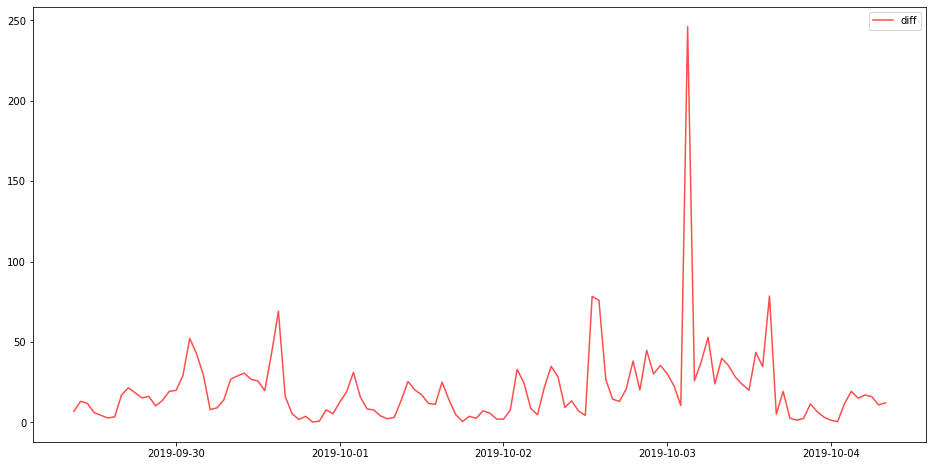

In [219]:
plt.figure(figsize=(16, 8))
plt.plot(df["diff"], c="red", label="diff", alpha=0.7)
plt.legend(loc='best')

## 観測値・予測値に関するデータフレーム の作成

In [150]:
def aqi_category(x):
    if x>=0 and x<=50:
        return "Good"
    elif x>50 and x<=100:
        return "Satisfactory"
    elif x>100 and x<=200:
        return "Moderately"
    elif x>200 and x<=300:
        return "Poor"
    elif x>300 and x<=400:
        return "VeryPoor"
    elif x>400 :
        return "Severe"

In [151]:
df_forecast=pd.DataFrame(ts_test.values,index=ts_test.index, columns=["original"])
df_forecast["forecast"]=sarimax_pred_forecast

In [152]:
df_forecast

,original,forecast
utc_time,,
2019-09-29 09:00:00,34.0,27.093694
2019-09-29 10:00:00,35.0,21.871493
2019-09-29 11:00:00,35.0,23.133422
2019-09-29 12:00:00,27.0,24.251552
2019-09-29 13:00:00,23.0,27.297297
...,...,...
2019-10-04 04:00:00,61.0,45.938713
2019-10-04 05:00:00,51.0,33.980098
2019-10-04 06:00:00,46.0,30.059857


### 1時間おきにカテゴリー変換して精度を計る

In [153]:
df_forecast["original_category"]=df_forecast["original"].apply(lambda x:aqi_category(x))
df_forecast["forecast_category"]=df_forecast["forecast"].apply(lambda x:aqi_category(x))

In [154]:
df_forecast

,original,forecast,original_category,forecast_category
utc_time,,,,
2019-09-29 09:00:00,34.0,27.093694,Good,Good
2019-09-29 10:00:00,35.0,21.871493,Good,Good
2019-09-29 11:00:00,35.0,23.133422,Good,Good
2019-09-29 12:00:00,27.0,24.251552,Good,Good
2019-09-29 13:00:00,23.0,27.297297,Good,Good
...,...,...,...,...
2019-10-04 04:00:00,61.0,45.938713,Satisfactory,Good
2019-10-04 05:00:00,51.0,33.980098,Satisfactory,Good
2019-10-04 06:00:00,46.0,30.059857,Good,Good


In [155]:
pd.crosstab(df_forecast["original_category"], df_forecast["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,71,8
Moderately,2,2
Satisfactory,32,4
VeryPoor,0,1


In [156]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_forecast["original_category"], df_forecast["forecast_category"], 
                 labels=["Good", "Satisfactory", "Moderately", "Poor", "VeryPoor",  "Severe"])

array([[71,  8,  0,  0,  0,  0],
       [32,  4,  0,  0,  0,  0],
       [ 2,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy_score ： {}".format(accuracy_score(df_forecast["original_category"], df_forecast["forecast_category"])))
print("precision_score ： {}".format(precision_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))
print("recall_score ： {}".format(recall_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))
print("f1_score ： {}".format(f1_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))

accuracy_score ： 0.625
precision_score ： 0.625
recall_score ： 0.625
f1_score ： 0.625


### 3時間おきにカテゴリー変換して精度を計る

In [158]:
df_forecast3=df_forecast.resample("3H").mean()

In [159]:
df_forecast3["original_category"]=df_forecast3["original"].apply(lambda x:aqi_category(x))
df_forecast3["forecast_category"]=df_forecast3["forecast"].apply(lambda x:aqi_category(x))

In [160]:
pd.crosstab(df_forecast3["original_category"], df_forecast3["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,23,2
Moderately,1,0
Satisfactory,12,2


In [161]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast3["original_category"], df_forecast3["forecast_category"])))

accuracy_score ： 0.625


### 6時間おきにカテゴリー変換して精度を計る

In [162]:
df_forecast6=df_forecast.resample("6H").mean()

df_forecast6["original_category"]=df_forecast6["original"].apply(lambda x:aqi_category(x))
df_forecast6["forecast_category"]=df_forecast6["forecast"].apply(lambda x:aqi_category(x))


In [163]:
pd.crosstab(df_forecast6["original_category"], df_forecast6["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,13,1
Moderately,0,1
Satisfactory,6,0


In [164]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast6["original_category"], df_forecast6["forecast_category"])))

accuracy_score ： 0.6190476190476191


### 12時間おきにカテゴリー変換して精度を計る

In [165]:
df_forecast12=df_forecast.resample("12H").mean()

df_forecast12["original_category"]=df_forecast12["original"].apply(lambda x:aqi_category(x))
df_forecast12["forecast_category"]=df_forecast12["forecast"].apply(lambda x:aqi_category(x))


In [166]:
pd.crosstab(df_forecast12["original_category"], df_forecast12["forecast_category"])

forecast_category,Good
original_category,
Good,6
Satisfactory,5


In [167]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast12["original_category"], df_forecast12["forecast_category"])))

accuracy_score ： 0.5454545454545454


### 24時間おきにカテゴリー変換して精度を計る

In [168]:
df_forecast24=df_forecast.resample("24H").mean()

df_forecast24["original_category"]=df_forecast24["original"].apply(lambda x:aqi_category(x))
df_forecast24["forecast_category"]=df_forecast24["forecast"].apply(lambda x:aqi_category(x))


In [169]:
pd.crosstab(df_forecast24["original_category"], df_forecast24["forecast_category"])

forecast_category,Good
original_category,
Good,3
Satisfactory,3


In [170]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast24["original_category"], df_forecast24["forecast_category"])))

accuracy_score ： 0.5


## 考察  

- 結果はARIMAで一気に5日間予測したものとほぼ同等  
- 平均をとってカテゴリー化すると外れ値の影響を受けやすくなる  


## 今後やること  
- 州ごとにまとめた(平均化した)データで予測モデルを構築する  
- 状態空間モデルとのアンサンブルを行う  